In [1]:
from models import *
import settings
import fnmatch

set_sql_debug(True)
db.bind(**settings.db_params)
# provider='postgres',user='postgres',password='example',host='localhost',dbname='EPMT')
db.generate_mapping(create_tables=True)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 8]

def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()



In [3]:
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print "not found",e
        return None
    print "Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads"
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] + (p.exename[exelen:] and '...')
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

In [ ]:
total, proc_dict = get_job_processes_reduce_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
for key, value in proc_dict.iteritems():
    labels.append(key)
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")

In [4]:
# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, exepatlist=[], cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    earliest = 0.0
    for p in processes:
        exename = p.exename[:exelen] + (p.exename[exelen:] and '...')
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)


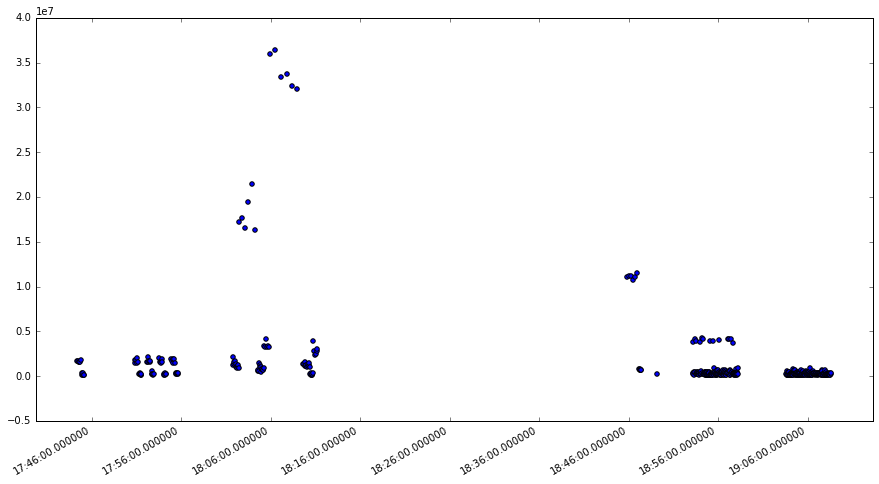

In [50]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

a = get_processes_job_filter(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', pat="gl")    
b = zip(*a)
plt.plot([],[])
plt.scatter(b[1],b[2])
plt.gcf().autofmt_xdate()

plt.show() 
#    value["duration"]
    #y_val.append()
#    print value["start"]
    #x_val.append(value["start"])

#x_val = [i for i in range(len(y_val))]
#print x_val, len(y_val)
##barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")
#barplot(labels=labels,y_val=y_val,mn="wall clock duration")
#barplot(labels=labels,y_val=y_val2,mn="invocations")

In [ ]:
#    for key, value in proc_dict.iteritems():
#        if value["threads"] > value["count"]:
#            print key, value["duration"], total, value["duration"]*100.0/total 
#        names["foo"] += 1
#        attr[p.exename] += p.duration



#jobs=select(j for j in Job if j.jobid == jobid)
#for j in jobs:
#    print "Job found:",j.jobname, j.jobid

# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels



In [ ]:
#    
    Process.select(lambda p: p.job == jobid)
    
    j.processes w# lookup job


    doit = False
        for pat in exepatlist:
            if fnmatch.fnmatch(p.exename, pat):
                doit = True
                break
        if not doit:
            continue
total, proc_dict = get_job_processes_full_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', exepatlist=["gl*"])

#print proc_dict
x_val = []
y_val = []
for key, value in proc_dict.iteritems():
    plt.plot([ i for i in range(len(value["start"]))],value["start"])
    plt.show()

print value["start"]

#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





In [ ]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [ ]:
print len(values[:])

In [ ]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 